Mushi
==
_All that the rain promises and more..._

A notebook for testing `mushi`'s ability to invert data simulated under the forward model

API documentation can be viewed with
```python
help(History)
help(kSFS)
```

In [1]:
%matplotlib notebook
import mushi
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import expit
import time
import msprime
%cd stdpopsim
from stdpopsim import homo_sapiens
%cd ../

/Users/williamdewitt/Desktop/repos/dement/stdpopsim
/Users/williamdewitt/Desktop/repos/dement


### Time grid

In [2]:
t = np.logspace(0, np.log10(3e4), 300)

### Demographic history $\eta(t)$ from the European population in Tennessen et al.

<IPython.core.display.Javascript object>


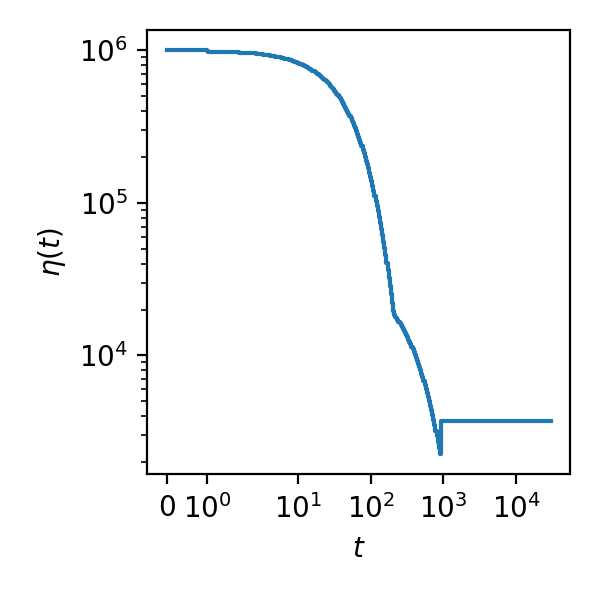

In [3]:
model = homo_sapiens.TennessenTwoPopOutOfAfrica()
dd = msprime.DemographyDebugger(Ne=model.default_population_size,
                                population_configurations=model.population_configurations,
                                demographic_events=model.demographic_events,
                                migration_matrix=model.migration_matrix)
y = 2 * dd.population_size_trajectory(np.concatenate(([0], t)))[:, 1]
η = mushi.η(t, y)

plt.figure(figsize=(3, 3))
η.plot()
plt.show()

### Mutation rate history $\mu(t)$
A 96 dimensional history with 3 underlying signatures:
- 10 identical pulses
- 10 identical ramping increases
- 76 identical constant
We will make the mutation rate low, so that the $k$-SFS is noisy and reconstruction of each of the 96 independently is difficult

<IPython.core.display.Javascript object>


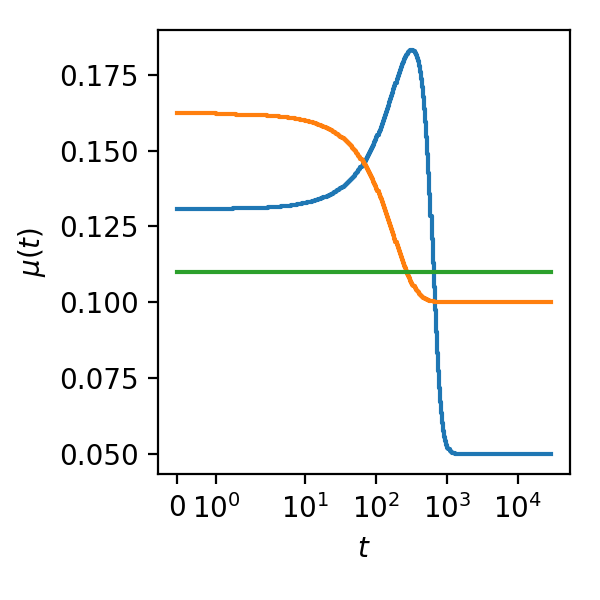

<IPython.core.display.Javascript object>


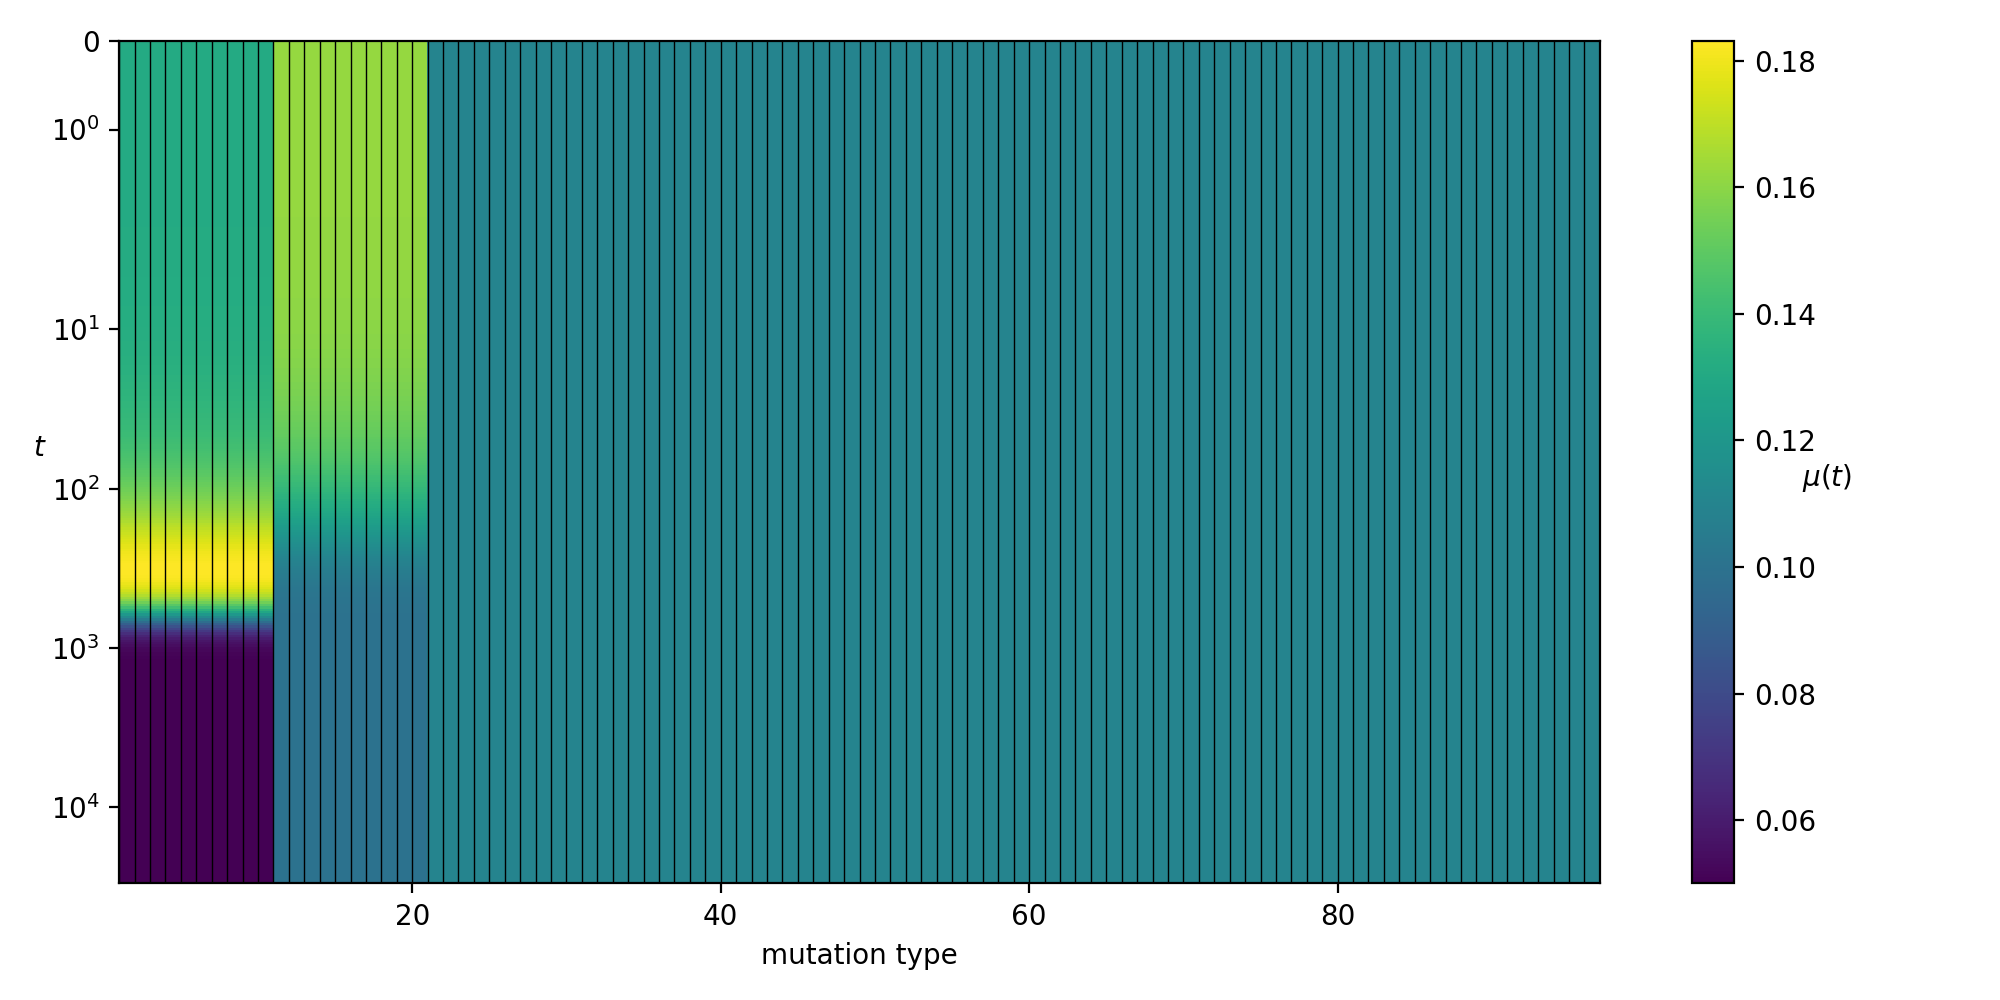

In [4]:
Z = np.zeros((len(t) + 1, 96))
tt = np.concatenate(([0], t))[:, np.newaxis]
μ0 = 0.1
flat = μ0 * (1.1 * np.ones_like(tt))
ramp = μ0 * (1 + expit(-.01 * (tt - 50)))
pulse = μ0 * (1 + expit(.01 * (tt - 80)) - 1.5 * expit(.01 * (tt - 600)))
Z[:, :10] += pulse #+ np.random.normal(0, .01, (1, 10))
Z[:, 10:20] += ramp #+ np.random.normal(0, .01, (1, 10))
Z[:, 20:] += flat #+ np.random.normal(0, .01, (1, 96 - 20))
μ = mushi.μ(t, Z)

plt.figure(figsize=(3, 3))
μ.plot((0, 10, 20))
plt.show()

plt.figure(figsize=(10, 5))
μ.heatmap()
plt.show()

### Simulate a $k$-SFS under this history
We'll sample 200 haplotypes, plot the first SFS and the CDF of the TMRCA of the sample

<IPython.core.display.Javascript object>


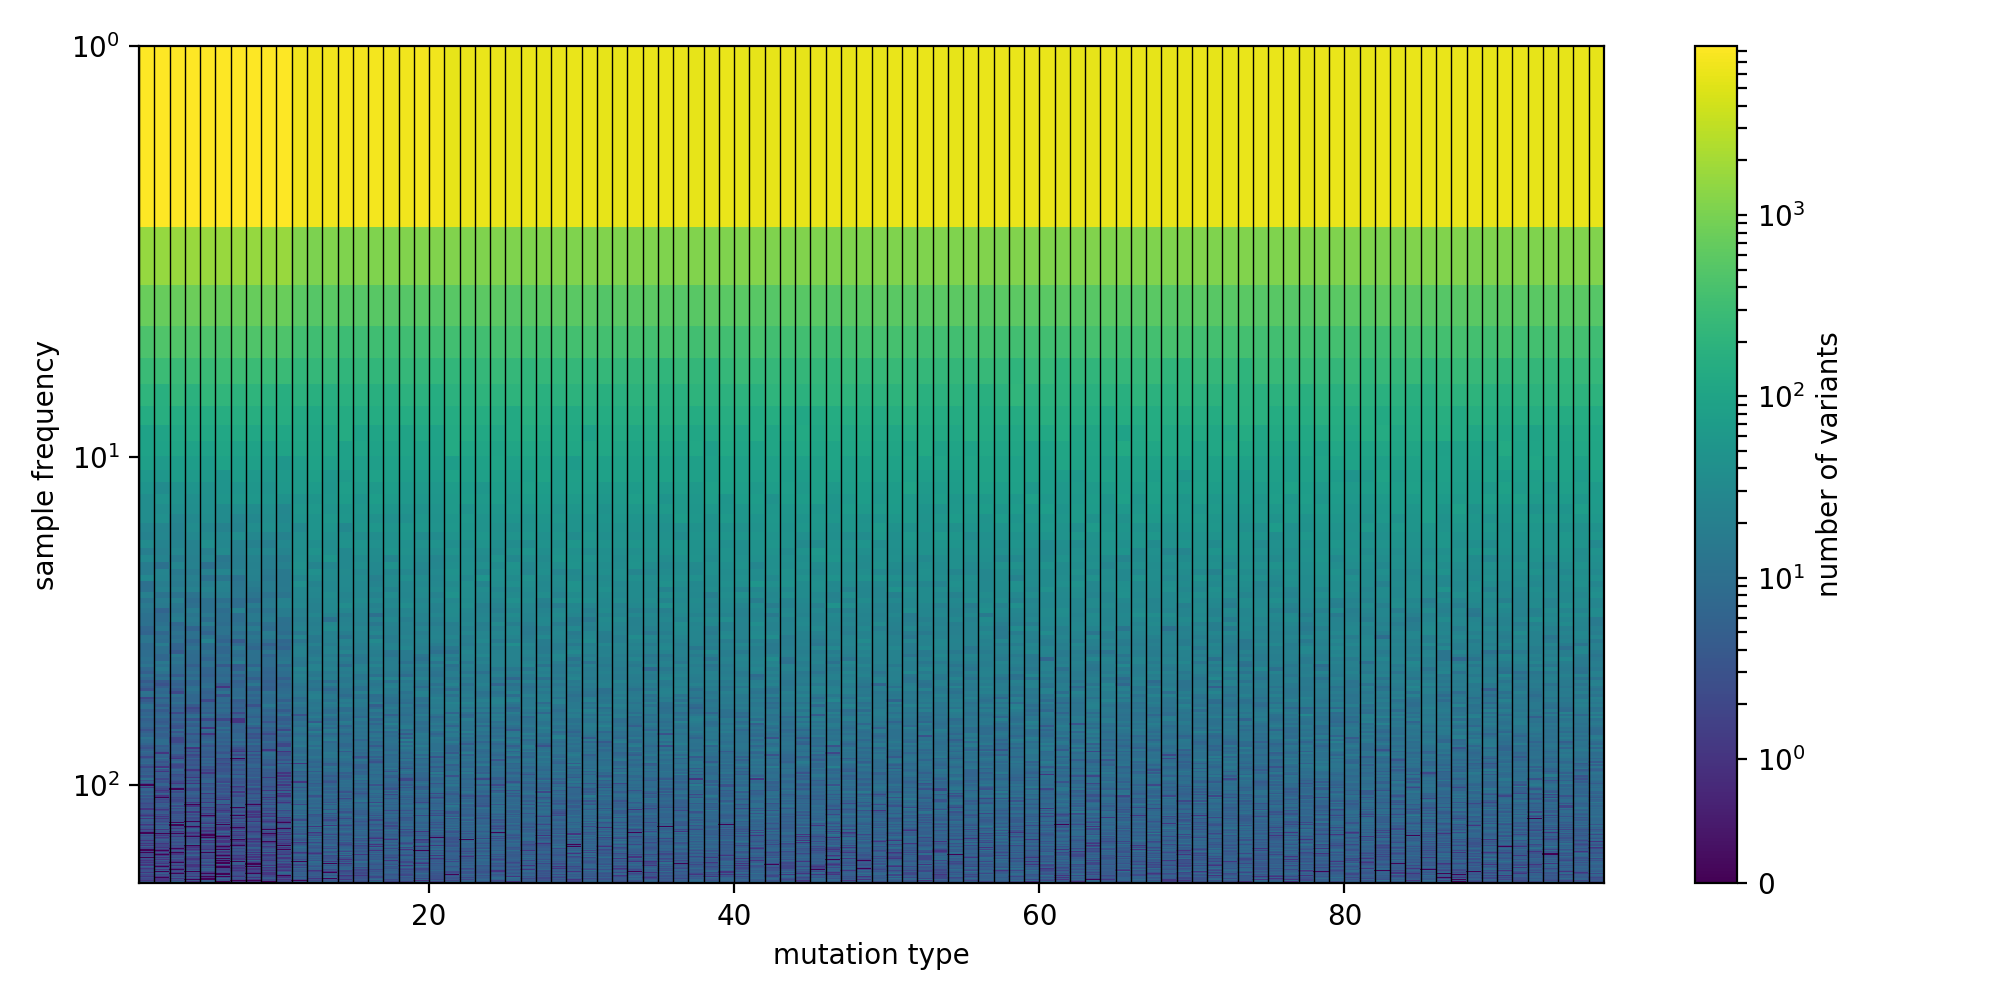

In [5]:
n = 200
sfs = mushi.kSFS(η, n=n)
sfs.simulate(μ, seed=1)

plt.figure(figsize=(10, 5))
sfs.heatmap()
plt.show()

### TMRCA CDF

<IPython.core.display.Javascript object>


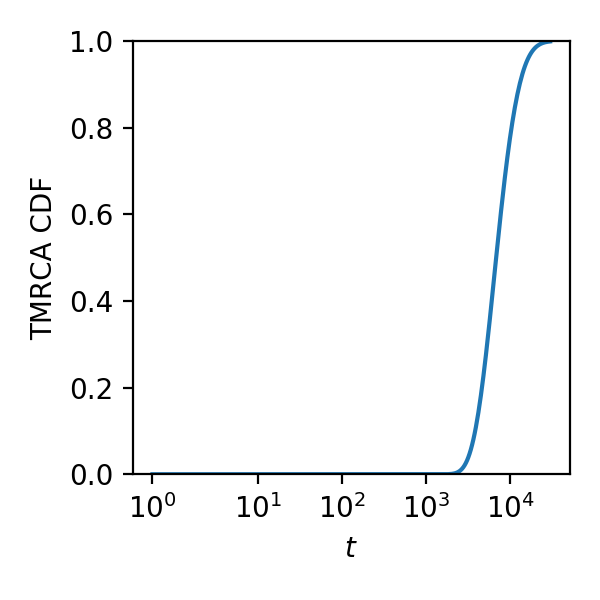

In [6]:
plt.figure(figsize=(3, 3))
plt.plot(η.change_points, sfs.tmrca_cdf())
plt.xlabel('$t$')
plt.ylabel('TMRCA CDF')
plt.ylim([0, 1])
plt.xscale('symlog')
plt.tight_layout()
plt.show()

### Invert the $k$-SFS conditioned on $\eta(t)$ to get $\boldsymbol\mu(t)$

In [7]:
λ_tv = 1e5
α_tv = 0#0.99
λ_r = 1e1
α_r = .99
γ = 0.8
max_iter = 10000
tol = 1e-10
bins = None
# bins = np.logspace(0, np.log10(n), 5)
with np.errstate(all='raise'):
    μ_inferred = sfs.infer_μ(λ_tv=λ_tv, α_tv=α_tv, λ_r=λ_r, α_r=α_r, γ=γ, max_iter=max_iter, tol=tol, bins=bins)

relative change in loss function 8.5e-11 is within tolerance 1e-10 after 647 iterations


<IPython.core.display.Javascript object>


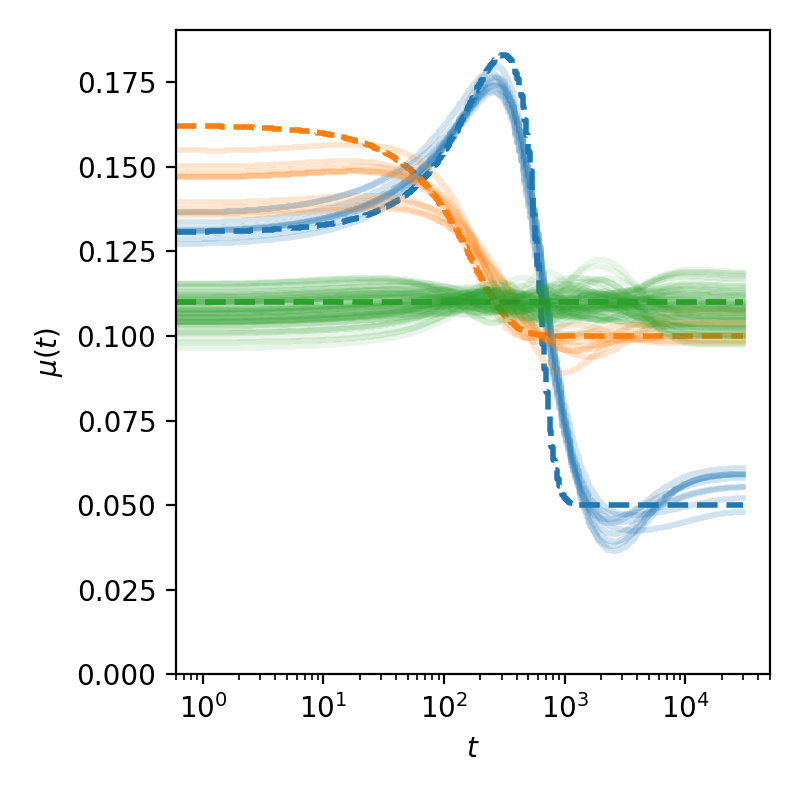

In [8]:
plt.figure(figsize=(4, 4))
plt.step(tt, pulse, c='C0', ls='--', lw=2)
plt.step(tt, ramp, c='C1', ls='--', lw=2)
plt.step(tt, flat, c='C2', ls='--', lw=2)
μ_inferred.plot(range(10), c='C0', alpha=0.2, lw=2)
μ_inferred.plot(range(10, 20), c='C1', alpha=0.2, lw=2)
μ_inferred.plot(range(20, 96), c='C2', alpha=0.1, lw=2)
plt.ylabel('$μ(t)$')
plt.xscale('log')
plt.ylim((0, None))
plt.tight_layout()
plt.show()

plot $\chi^2$ goodness of fit for each matrix element, and compute $\chi^2$ goodness of fit test for the matrix as a whole

<IPython.core.display.Javascript object>


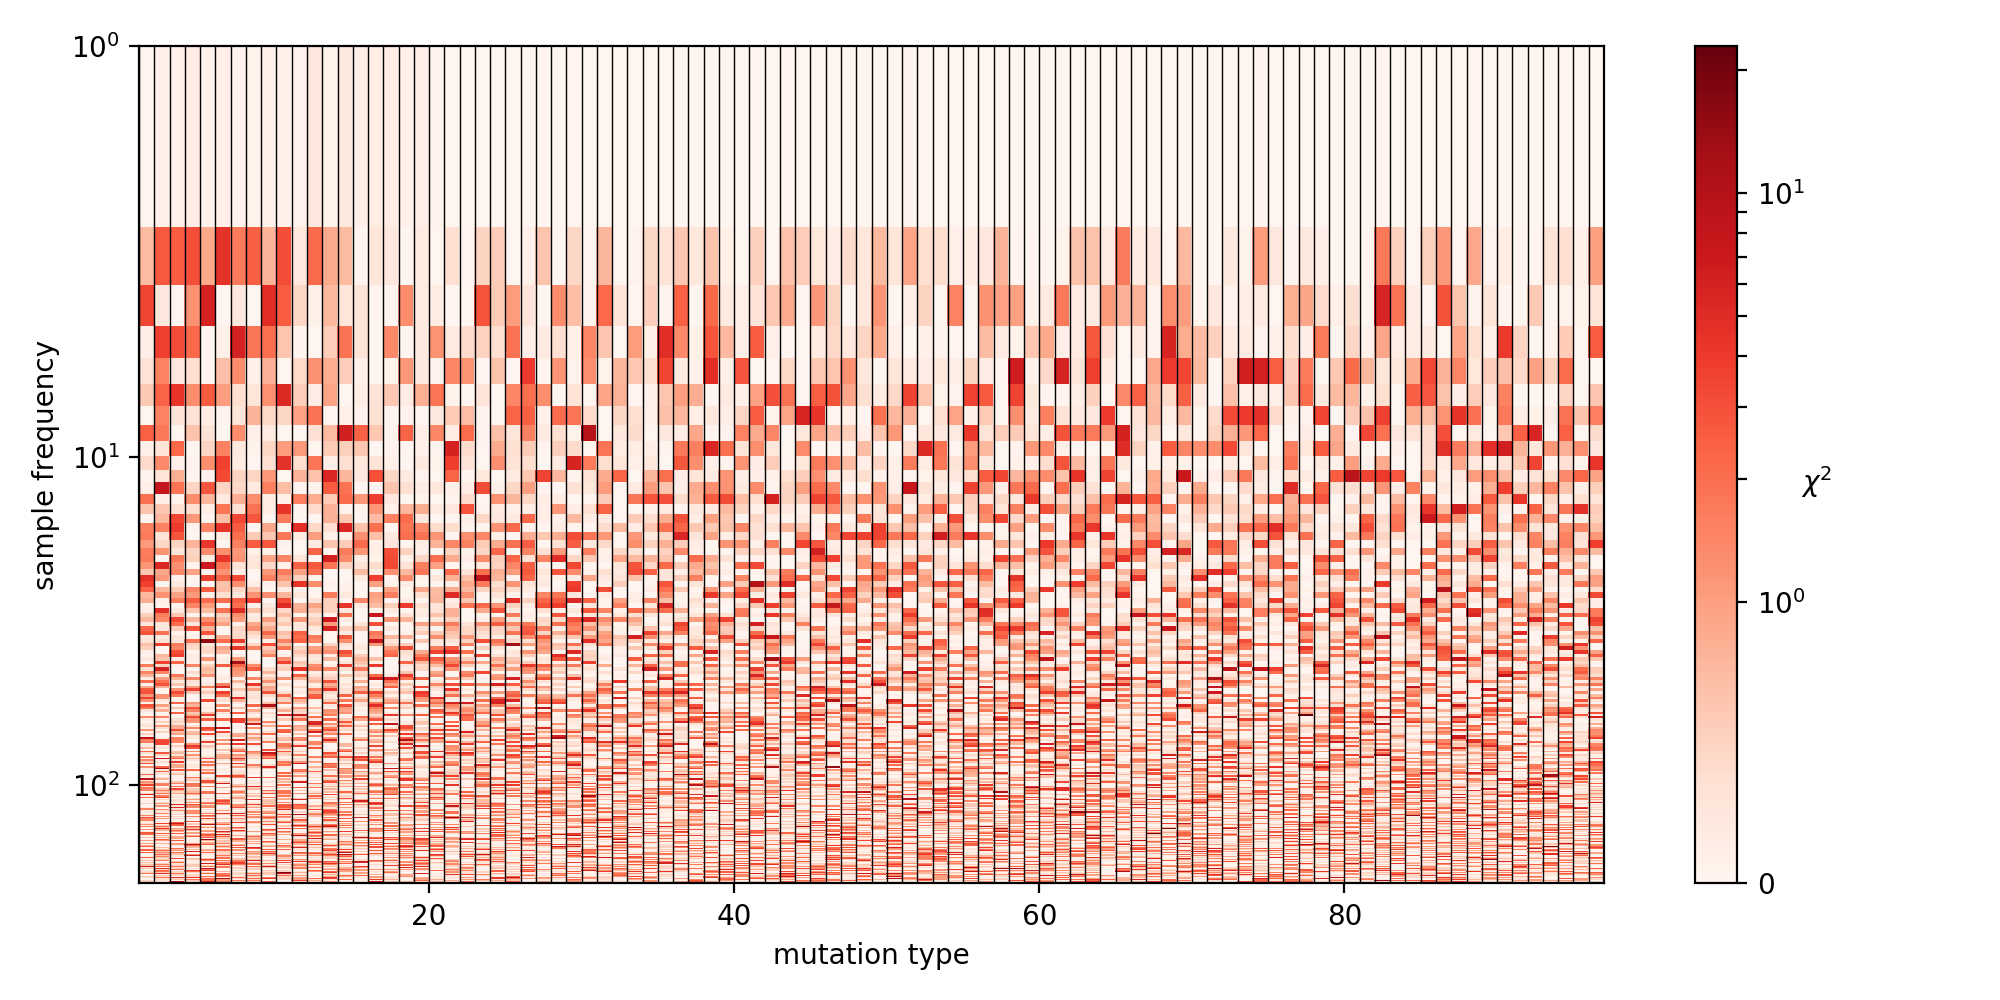

χ² goodness of fit 18527.19741912316, p = 0.9985478194062698


In [9]:
plt.figure(figsize=(10, 5))
sfs.heatmap(μ_inferred)
plt.show()

An example column from each of the three signatures

<IPython.core.display.Javascript object>


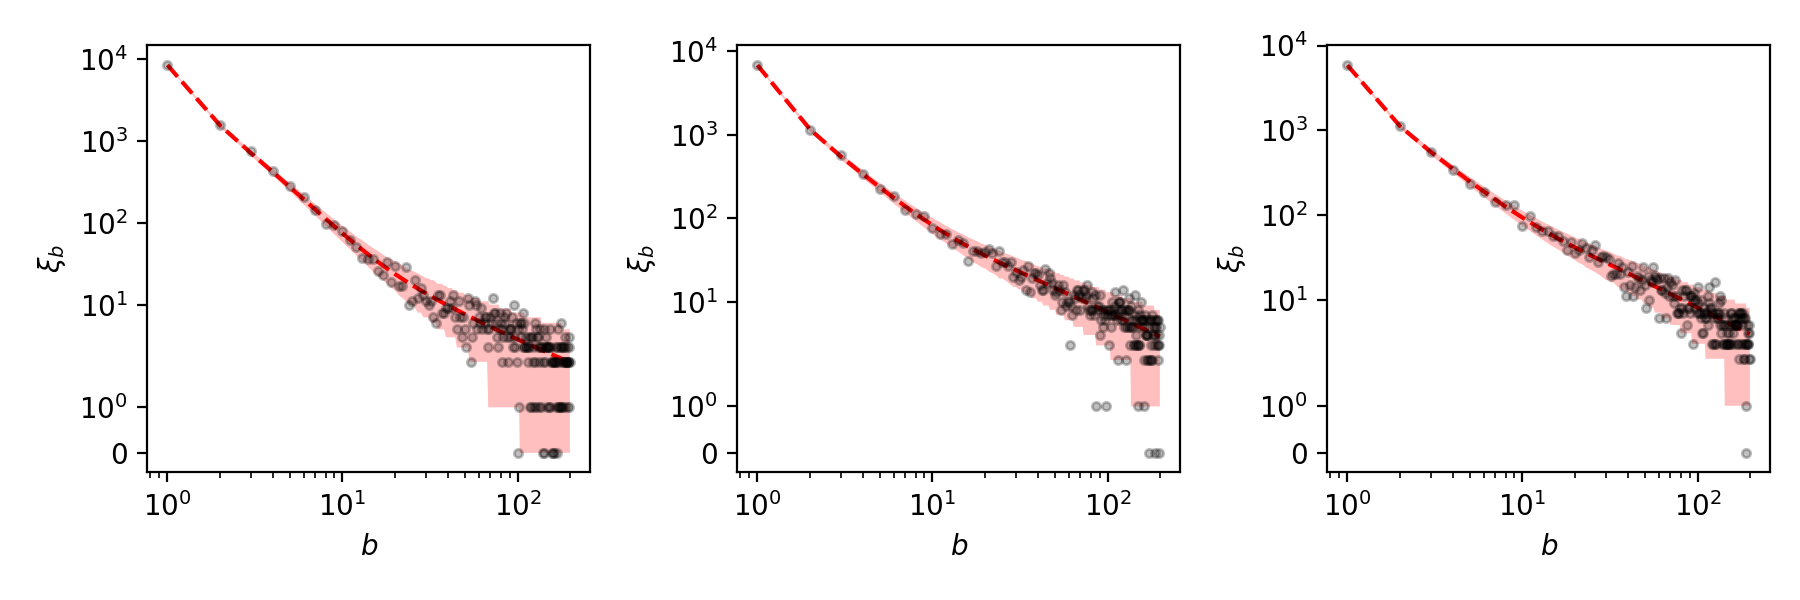

In [10]:
plt.figure(figsize=(9, 3))
for ct, i in enumerate((0, 10, 20), 1):
    plt.subplot(1, 3, ct)
    sfs.plot(i, μ=μ_inferred, prf_quantiles=True)
plt.tight_layout()
plt.show()

### Singular value spectrum of $Z$

<IPython.core.display.Javascript object>


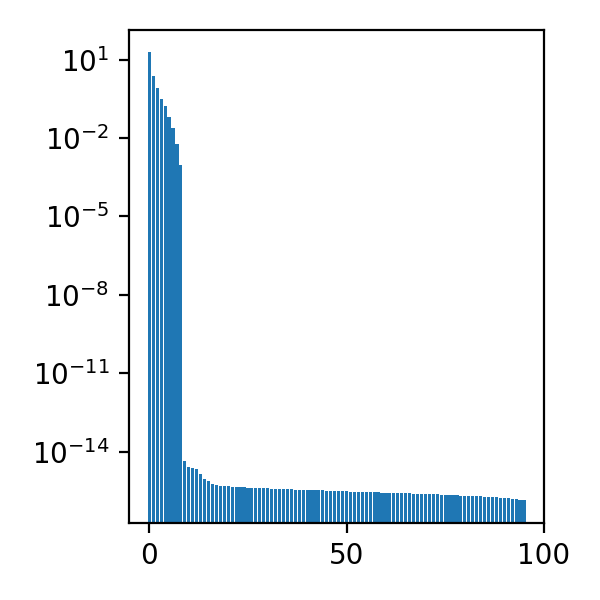

In [11]:
plt.figure(figsize=(3, 3))
plt.bar(range(μ.Z.shape[1]), np.linalg.svd(μ_inferred.Z, compute_uv=False))
plt.yscale('log')
plt.tight_layout()
plt.show()